In [53]:
import pandas as pd

import sys, os, requests, json, datetime
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

## transauction (purchase) and transauctiondonation

In [157]:
# get auction donations & purchases
q = "select * from transauction"
df_purchases = redshift_query_read(q, schema="production")
df_purchases['createddate'] = pd.to_datetime(df_purchases['createddate'])

q = "select * from transauctiondonation"
df_donations = redshift_query_read(q, schema="production")
df_donations['createddate'] = pd.to_datetime(df_donations['createddate'])

In [158]:
# get auction transactions
df_trans = get_dataframe_from_file("trans-records", "trans.auction_forms.csv")

In [159]:
# narrowing transactions dataframe
auction_forms = list(set(df_purchases['form'].unique().tolist() + df_donations['form'].unique().tolist()))
df_trans = df_trans[df_trans['form'].isin(auction_forms)]
len(auction_forms), len(df_trans['form'].unique())

(116, 55)

In [160]:
auction_transactions = list(set(df_purchases['transaction'].unique().tolist() + df_donations['transaction'].unique().tolist()))
#auction_transactions = df_purchases['transaction'].unique().tolist()
df = df_trans[df_trans['id'].isin(auction_transactions)][['id', 'form', 'amount', 'status', 'date']]

In [161]:
print("ALL TRANSACTIONS")
print(df_trans.groupby('status')['id'].count())
print("AUCTION FILTERED TRANSACTIONS")
print(df.groupby('status')['id'].count())

ALL TRANSACTIONS
status
A     7477
CR     711
D      644
E      134
U       37
Name: id, dtype: int64
AUCTION FILTERED TRANSACTIONS
status
A     2153
CR      84
U       11
Name: id, dtype: int64


In [162]:
len(df), len(df['form'].unique())

(2248, 55)

In [163]:
df.head(3)

,id,form,amount,status,date
99,7851207,948883,1.0,A,2019-09-06
127,7855941,949088,80.0,A,2019-09-07
128,7855944,949088,105.0,A,2019-09-07


## event settings

In [164]:
def fetch_table(table):
    url = 'https://secure.qgiv.com/admin/qgivadmin/statistics/export_tables.php'
    payload = {'key': 'DSQR59VwyFhw21PKDF4K', 'table': table}

    rsp = requests.post(url, data=payload)
    json_data = json.loads(rsp.content)

    return json_data

In [165]:
data = fetch_table("eventsettings")
len(data), len(data[0])

(1, 9739)

In [166]:
es = pd.DataFrame(data[0])
es.head(3)

,additionalNonFundraising,additionalRegistrants,alias,allowUnattachedMatch,allowableEmergencyContacts,allowableEmergencyContactsForSub,cacheLimit,classificationLabel,classificationLimitDisplayTeamThreshold,classificationLimitDisplayThreshold,...,totalCheck,totalMatching,totalOfflineUnverified,totalOfflineVerified,totalOnline,totalRaised,transNotification,twitterUrl,unverifiedDonations,videoUrl
0,0,1,hobnob,0,0,0,0,Classifications,10,10,...,0.00,0.00,17646.54,7910.54,17030.44,42587.52,,twitter.com/Qgiv,3,https://www.youtube.com/watch?v=6y71y2aTR5k
1,0,0,cob,0,1,0,5,Location,10,10,...,0.00,0.00,285.18,2436.50,5345.00,8066.68,None,http://twitter.com/#!/JewishBU,2,
2,0,1,thwfmhai,0,0,0,5,Agency,10,10,...,305.00,0.00,1470.50,50.00,11507.70,13028.20,None,,2,


In [167]:
[c for c in es.columns if 'id' in c or 'start' in c or 'form' in c or 'end' in c]

['enableIndividualRegistration',
 'endDate',
 'form',
 'id',
 'startDate',
 'videoUrl']

In [168]:
settings = es[['form', 'startDate', 'endDate']].copy()
settings['form'] = settings['form'].astype(int)
settings['startDate'] = pd.to_datetime(settings['startDate'], errors='coerce')
settings['endDate'] = pd.to_datetime(settings['endDate'], errors='coerce')

In [169]:
print("total: {}; no start date: {}".format(len(settings), len(settings[settings['startDate'].isna()])))
settings.head(3)

total: 9739; no start date: 5769


,form,startDate,endDate
0,1391,NaT,NaT
1,1392,NaT,NaT
2,1419,NaT,NaT


In [170]:
forms_that_processed = df['form'].unique().tolist()

settings_rfnd = settings[settings['form'].isin(forms_that_processed)]

print("total: {}; no start date: {}; start date in 2030: {}".format(len(settings_rfnd), len(settings_rfnd[settings_rfnd['startDate'].isna()]), len(settings_rfnd[settings_rfnd['startDate'].dt.year==2030])))
settings_rfnd.head(3)

total: 55; no start date: 3; start date in 2030: 22


,form,startDate,endDate
5574,947230,2020-03-06 16:00:00,2020-03-06 17:05:00
5770,948006,2019-12-07 04:00:00,2019-12-07 09:00:00
5907,948523,2030-01-01 00:00:00,2030-01-01 00:00:00


## merging data

In [171]:
df = df[df['form'].isin(forms_that_processed)]
df['date'] = pd.to_datetime(df['date'])
grpd = df.groupby('form')['date'].agg({'first': 'first', 'last': 'last', 'count': 'count'}).reset_index()
grpd['duration_processing'] = grpd['last'] - grpd['first']
grpd.head()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,form,first,last,count,duration_processing
0,947230,2020-01-13,2020-01-13,1,0 days
1,948006,2019-10-08,2019-10-08,1,0 days
2,948523,2019-10-05,2019-10-11,25,6 days
3,948619,2019-10-12,2019-10-13,114,1 days
4,948694,2019-09-26,2019-09-27,23,1 days


In [172]:
mrgd = df.merge(grpd, on="form").merge(settings, on="form")
mrgd['time_since_first'] = mrgd['date'] - mrgd['first']
mrgd['time_until_last'] = mrgd['last'] - mrgd['date']
mrgd['time_since_beginning'] = mrgd['date'] - mrgd['startDate']
mrgd['time_until_end'] = mrgd['date'] - mrgd['endDate']
mrgd['time_since_end'] = mrgd['startDate'] - mrgd['date']

In [173]:
print("Means (excluding 2030 starts):")
print(mrgd[mrgd['startDate'].dt.year!=2030][['time_since_first', 'time_until_last', 'time_since_beginning', 'time_until_end', 'time_since_end']].mean())

Means (excluding 2030 starts):
time_since_first         1 days 00:02:08.380386
time_until_last          7 days 01:42:42.258543
time_since_beginning     2 days 05:49:36.823266
time_until_end           0 days 02:46:52.751677
time_since_end         -3 days +18:10:23.176733
dtype: timedelta64[ns]


In [174]:
len(mrgd), len(mrgd[~mrgd['startDate'].isna()])

(2248, 2243)

In [175]:
mrgd.head(3)

,id,form,amount,status,date,first,last,count,duration_processing,startDate,endDate,time_since_first,time_until_last,time_since_beginning,time_until_end,time_since_end
0,7851207,948883,1.0,A,2019-09-06,2019-09-06,2019-09-06,1,0 days,NaT,NaT,0 days,0 days,NaT,NaT,NaT
1,7855941,949088,80.0,A,2019-09-07,2019-09-07,2019-09-10,12,3 days,2030-01-01,2030-01-01,0 days,3 days,-3769 days,-3769 days,3769 days
2,7855944,949088,105.0,A,2019-09-07,2019-09-07,2019-09-10,12,3 days,2030-01-01,2030-01-01,0 days,3 days,-3769 days,-3769 days,3769 days


### time since first quantiles

In [176]:
form_data = []
for form in mrgd['form'].unique():
    _df = mrgd[mrgd['form']==form].sort_values('time_since_first', ascending=True)
    
    quantile = _df[_df['time_since_first'].dt.total_seconds()>0]['time_since_first'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0])
    quantile['form'] = form
    
    form_data.append(quantile)

In [177]:
qs = pd.DataFrame(form_data)
qs[[0.5, 0.75, 0.9]].mean()

0.50    9 days 09:52:56.470588
0.75           9 days 18:00:00
0.90   10 days 12:04:14.117647
dtype: timedelta64[ns]

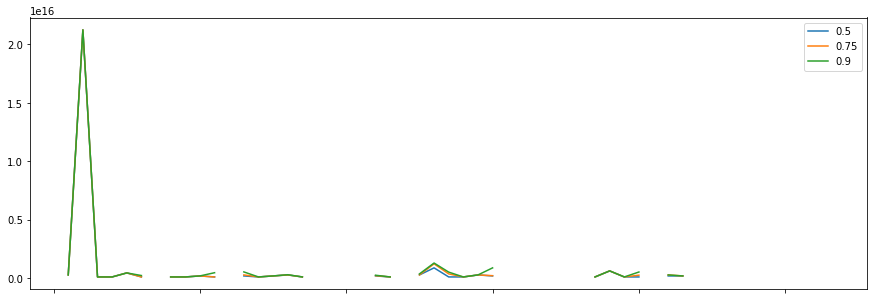

In [178]:
qs[[0.5, 0.75, 0.9]].plot(figsize=(15,5))

### time since settings end date quantiles

In [179]:
form_data = []
for form in mrgd['form'].unique():
    _df = mrgd[(mrgd['form']==form)&(mrgd['endDate'].dt.year!=2030)].sort_values('time_since_end', ascending=True)
    
    if len(_df) > 0:
        quantile = _df[_df['time_since_end'].dt.total_seconds()>0]['time_since_end'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0])
        quantile['form'] = form

        form_data.append(quantile)

In [180]:
qs = pd.DataFrame(form_data)
qs[[0.5, 0.75, 0.9]].mean()

0.50   8 days 05:48:44
0.75   8 days 05:48:44
0.90   8 days 05:48:44
dtype: timedelta64[ns]

### time since settings start date quantiles

In [191]:
form_data = []
for form in mrgd[(mrgd['startDate'].dt.year==2020)|(mrgd['startDate'].dt.year==2019)]['form'].unique():
    _df = mrgd[mrgd['form']==form].sort_values('time_since_beginning', ascending=True)
    
    quantile = _df[_df['date']>_df['startDate']]['time_since_beginning'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0])
    quantile['form'] = form
    
    form_data.append(quantile)

In [192]:
qs = pd.DataFrame(form_data)
qs[[0.1, 0.5, 0.75, 0.9]].mean()

0.10   2 days 14:02:32.500000
0.50   3 days 00:02:32.500000
0.75   3 days 10:17:32.500000
0.90   3 days 21:20:32.499999
dtype: timedelta64[ns]

# cohorts by timeframe

In [193]:
days = [(0, 3), (3, 7), (7, 30), (30, None)]

In [194]:
for day_filter in days:
    if day_filter[1] is None:
        this_qs = qs[qs[0.9].dt.days>day_filter[0]]
    else:
        this_qs = qs[(qs[0.9].dt.days > day_filter[0])&(qs[0.9].dt.days < day_filter[1])]
    print("{} ({} forms)".format(day_filter, len(this_qs['form'].unique())))
    print("10% to 90% closed: {}".format(this_qs[0.9].mean() - this_qs[0.1].mean()))
    print(this_qs[[0.25, 0.5, 0.75, 0.9]].mean())
    print()

(0, 3) (8 forms)
10% to 90% closed: 1 days 03:18:00
0.25   0 days 18:59:15
0.50   1 days 00:59:15
0.75   1 days 07:44:15
0.90   1 days 19:17:15
dtype: timedelta64[ns]

(3, 7) (5 forms)
10% to 90% closed: 1 days 05:45:35.999999
0.25          4 days 02:44:48
0.50          4 days 07:32:48
0.75          4 days 07:32:48
0.90   5 days 08:30:23.999999
dtype: timedelta64[ns]

(7, 30) (3 forms)
10% to 90% closed: 1 days 08:00:00
0.25   10 days 17:00:00
0.50   12 days 01:00:00
0.75   12 days 01:00:00
0.90   12 days 01:00:00
dtype: timedelta64[ns]

(30, None) (0 forms)
10% to 90% closed: NaT
0.25   NaT
0.50   NaT
0.75   NaT
0.90   NaT
dtype: timedelta64[ns]



In [195]:
non_zero = qs[qs[0.9].dt.total_seconds()!=0]

print("Total: {}".format(len(non_zero)))
print("90% concluded in less than 1 day: {:.2f}".format(len(non_zero[non_zero[0.9].dt.days<1]) / len(qs)))
print("90% concluded in less than 12 hours: {:.2f}".format(len(non_zero[non_zero[0.9].dt.total_seconds()<=(12 * 60 * 60)]) / len(qs)))
print("90% concluded in less than 6 hours: {:.2f}".format(len(non_zero[non_zero[0.9].dt.total_seconds()<=(6 * 60 * 60)]) / len(qs)))
print("90% concluded in less than 3 hours: {:.2f}".format(len(non_zero[non_zero[0.9].dt.total_seconds()<=(3 * 60 * 60)]) / len(qs)))
print("90% concluded in less than 1 hour: {:.2f}".format(len(non_zero[non_zero[0.9].dt.total_seconds()<=(60 * 60)]) / len(qs)))

Total: 30
90% concluded in less than 1 day: 0.17
90% concluded in less than 12 hours: 0.13
90% concluded in less than 6 hours: 0.07
90% concluded in less than 3 hours: 0.00
90% concluded in less than 1 hour: 0.00


# Chris' spreadsheet

Values requested: form per row with the **_columns ID, form name, org name, % closed w/in 1 hour, % closed w/in 3 hours, % closed w/in 6 hours, % closed w/in 12 hours, % closed w/in 1 day, total hours to 95% closed, total hours to 100% closed_**

In [196]:
# get the 95% & 100% closed values
form_total_closed = qs[qs[1.0].dt.total_seconds()!=0][['form', 0.95, 1.0]]
form_total_closed['hours to 95% closed'] = form_total_closed[0.95].dt.total_seconds() / (60 * 60)
form_total_closed['hours to 100% closed'] = form_total_closed[1.0].dt.total_seconds() / (60 * 60)
form_total_closed.drop([0.95, 1.0], axis=1, inplace=True)
form_total_closed.head()

,form,hours to 95% closed,hours to 100% closed
time_since_beginning,948968,29.0,29.0
time_since_beginning,948694,54.0,54.0
time_since_beginning,949232,295.0,415.0
time_since_beginning,948006,NaN,NaN
time_since_beginning,948619,144.0,144.0


In [197]:
# get %'s complete by time
completion_data = []
for form in qs['form'].unique():
    _df = mrgd[mrgd['form']==form].sort_values('time_since_end', ascending=True)
    len_all = len(_df)
    
    data = {
        'form': form,
        'total winning bids': len_all,
        'total transactions': len(_df['id'].unique()),
        '% complete 1 hour': len(_df[_df['time_since_end'].dt.total_seconds()<(60 * 60)]) / len_all,
        '% complete 3 hour': len(_df[_df['time_since_end'].dt.total_seconds()<(3 * 60 * 60)]) / len_all,
        '% complete 6 hour': len(_df[_df['time_since_end'].dt.total_seconds()<(6 * 60 * 60)]) / len_all,
        '% complete 12 hour': len(_df[_df['time_since_end'].dt.total_seconds()<(12 * 60 * 60)]) / len_all,
        '% complete 24 hour': len(_df[_df['time_since_end'].dt.total_seconds()<(24 * 60 * 60)]) / len_all
    }
    
    completion_data.append(data)

In [198]:
completion_df = pd.DataFrame(completion_data)

print(len(completion_df), len(mrgd['form'].unique()), len(form_total_closed['form'].unique()))
completion_df.head()

30 55 30


,% complete 1 hour,% complete 12 hour,% complete 24 hour,% complete 3 hour,% complete 6 hour,form,total transactions,total winning bids
0,1.0,1.0,1.0,1.0,1.0,948968,33,33
1,1.0,1.0,1.0,1.0,1.0,948694,23,23
2,1.0,1.0,1.0,1.0,1.0,949232,68,68
3,0.0,0.0,0.0,0.0,0.0,948006,1,1
4,1.0,1.0,1.0,1.0,1.0,948619,114,114


In [199]:
completion_mrgd = completion_df.merge(form_total_closed, on='form')

cols = ['form', 'total transactions', '% complete 1 hour', '% complete 3 hour',
       '% complete 6 hour', '% complete 12 hour', '% complete 24 hour',
       'hours to 95% closed', 'hours to 100% closed']
print(len(completion_mrgd))
completion_mrgd[cols].head()

30


,form,total transactions,% complete 1 hour,% complete 3 hour,% complete 6 hour,% complete 12 hour,% complete 24 hour,hours to 95% closed,hours to 100% closed
0,948968,33,1.0,1.0,1.0,1.0,1.0,29.0,29.0
1,948694,23,1.0,1.0,1.0,1.0,1.0,54.0,54.0
2,949232,68,1.0,1.0,1.0,1.0,1.0,295.0,415.0
3,948006,1,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,948619,114,1.0,1.0,1.0,1.0,1.0,144.0,144.0


In [200]:
forms = redshift_query_read("select id, org from form", schema="production")

In [201]:
completion_mrgd['org'] = completion_mrgd['form'].apply(lambda x: forms[forms['id']==x]['org'].iloc[0])
completion_mrgd[['org'] + cols].head()

,org,form,total transactions,% complete 1 hour,% complete 3 hour,% complete 6 hour,% complete 12 hour,% complete 24 hour,hours to 95% closed,hours to 100% closed
0,443324,948968,33,1.0,1.0,1.0,1.0,1.0,29.0,29.0
1,443779,948694,23,1.0,1.0,1.0,1.0,1.0,54.0,54.0
2,444558,949232,68,1.0,1.0,1.0,1.0,1.0,295.0,415.0
3,443382,948006,1,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,39915,948619,114,1.0,1.0,1.0,1.0,1.0,144.0,144.0


In [202]:
one_hour = len(completion_mrgd[completion_mrgd['% complete 1 hour']==1.]) / len(completion_mrgd)
twelve_hour = len(completion_mrgd[completion_mrgd['% complete 12 hour']==1.]) / len(completion_mrgd)
twentyfour_hour = len(completion_mrgd[completion_mrgd['% complete 24 hour']==1.]) / len(completion_mrgd)

print("1 hour: {:.2f}%".format(one_hour * 100.))
print("12 hour: {:.2f}%".format(twelve_hour * 100.))
print("24 hour: {:.2f}%".format(twentyfour_hour * 100.))

1 hour: 50.00%
12 hour: 56.67%
24 hour: 90.00%


In [128]:
#completion_mrgd[['org'] + cols].to_csv("auctions.don_n_purch.csv", index=False)
completion_mrgd[['org'] + cols].to_csv("auctions.purch.csv", index=False)

In [38]:
com_df = completion_mrgd[['org'] + cols]
len(com_df), com_df[com_df['form']==953775]['total transactions']

(30,
 23    70
 Name: total transactions, dtype: int64)

In [37]:
completion_mrgd[cols].mean()

form                    951839.909091
total transactions          32.545455
% complete 1 hour            0.564483
% complete 3 hour            0.564483
% complete 6 hour            0.564483
% complete 12 hour           0.603625
% complete 24 hour           0.818182
hours to 95% closed        197.812222
hours to 100% closed       197.812222
dtype: float64

# spot checking form 953775

source: auction purchased items, auction donations

- donations: 25, \$2930, 7 declined
- purchases: 124 items, $63335
- total: \$66265
- checkins: 186
- total paid: 70

15 purchases w/ no attendee status, 1 checked in, 108 paid, 2 w/ amounts (totalling \$6400) with no transaction

In [7]:
form = 953775
q = "select * from transactions where form={} and status='A' and date>='3/13/2020'".format(form)
df = redshift_query_read(q)

In [8]:
print("transaction count: {}".format(len(df)))
print("transaction count > $0: {}".format(len(df[df['amount']>0.])))
print("transaction sum: ${:.2f}".format(df['amount'].sum()))

transaction count: 267
transaction count > $0: 86
transaction sum: $54680.59


In [9]:
q = "select * from transauction where form={} and status=1".format(form)
transauction = redshift_query_read(q, schema='production')

In [10]:
print("auction count: {}".format(len(transauction)))
print("auction sum: ${:.2f}".format(transauction['total'].sum()))
print("unique trans auction count: {}".format(transauction.groupby('transaction')['total'].first().count()))
print("unique trans auction sum: ${:.2f}".format(transauction.groupby('transaction')['total'].first().sum()))

auction count: 184
auction sum: $99280.00
unique trans auction count: 61
unique trans auction sum: $37170.00


In [11]:
print("Transaction times:")
print("{} - {}".format(df['date'].min(), df['date'].max()))
print("Transauction times:")
print("{} - {}".format(transauction['createddate'].min(), transauction['createddate'].max()))

Transaction times:
2020-03-13 00:00:00 - 2020-03-17 00:00:00
Transauction times:
2020-03-14 11:52:07 - 2020-03-14 22:17:27


# spot checking form 948619

- purchases: 355, \$29,735
- donations: 20, \$9,312
- total: \$39,047

21 purchases w/out checked out status & no transaction, 35 checked out status (not paid)

In [13]:
form = 948619
q = "select * from transactions where form={} and status='A'".format(form)
df = redshift_query_read(q)

In [14]:
print("transaction count: {}".format(len(df)))
print("transaction count > $0: {}".format(len(df[df['amount']>0.])))
print("transaction sum: ${:.2f}".format(df['amount'].sum()))

transaction count: 276
transaction count > $0: 166
transaction sum: $50342.50


In [19]:
q = "select * from transauction where form={} and status=1".format(form)
transauction = redshift_query_read(q, schema='production')
q = "select * from transauctiondonation where form={} and status=1".format(form)
transauctiondonation = redshift_query_read(q, schema='production')

In [16]:
print("auction count: {}".format(len(transauction)))
print("auction sum: ${:.2f}".format(transauction['total'].sum()))
print("unique trans auction count: {}".format(transauction.groupby('transaction')['total'].first().count()))
print("unique trans auction sum: ${:.2f}".format(transauction.groupby('transaction')['total'].first().sum()))

auction count: 578
auction sum: $32160.00
unique trans auction count: 109
unique trans auction sum: $4635.00


In [20]:
print("donations + purchases")
print("auction count: {} ({} purchases, {} donations)".format(len(transauction) + len(transauctiondonation), len(transauction), len(transauctiondonation)))
print("auction sum: ${:.2f}".format(transauction['total'].sum() + transauctiondonation['amount'].sum()))
print("unique trans auction count: {}".format(transauction.groupby('transaction')['total'].first().count() + transauctiondonation.groupby('transaction')['amount'].first().count()))
print("unique trans auction sum: ${:.2f}".format(transauction.groupby('transaction')['total'].first().sum() + transauctiondonation.groupby('transaction')['amount'].first().count()))

donations + purchases
auction count: 623 (578 purchases, 45 donations)
auction sum: $44370.00
unique trans auction count: 154
unique trans auction sum: $4680.00


In [17]:
print("Transaction times:")
print("{} - {}".format(df['date'].min(), df['date'].max()))
print("Transauction times:")
print("{} - {}".format(transauction['createddate'].min(), transauction['createddate'].max()))

Transaction times:
2019-08-21 00:00:00 - 2019-11-03 00:00:00
Transauction times:
2019-10-12 13:18:11 - 2019-10-12 20:56:58
